In [1]:
from util.GurobiOptimizer import GurobiOptimizer
import numpy as np

In [ ]:
# GurobiOptimizer = GurobiOptimizer()
# solution = GurobiOptimizer.run_full_optimization()

Processing series: 100%|██████████| 153/153 [13:13<00:00,  5.19s/series]


In [ ]:
initial_demands, final_grid_demands, charging_demands, soc_t_v_s, optimal_objectives, optimization_times, mip_gaps, self_sufficiencies, pv_utilizations = solution

In [5]:
print(np.array(self_sufficiencies).mean(), np.array(pv_utilizations).mean())
print(np.array(self_sufficiencies).std(), np.array(pv_utilizations).std())

0.4569165745086894 0.9664461290009903
0.10280459572448873 0.030298334374897238


In [ ]:
# import matplotlib.pyplot as plt
# from pyparsing import col

# print(sum(charging_demand))
# print([round(float(i),2) for i in pv])
# print(len(pv))
# plt.figure(figsize=(12, 6))
# plt.step(range(len(initial_demand)), initial_demand , label='Initial Demand', where='post')
# plt.step(range(len(final_grid_demand)), final_grid_demand, label='Final Demand', color='black', where='post')
# plt.step(range(len(charging_demand)), [final_grid_demand[i] - charging_demand[i] for i in range(len(charging_demand))], label='Charging Demand', color='orange', where='post')
# plt.xlabel('Time Step')
# plt.ylabel('Demand (kW)')
# plt.title('Demand Comparison')
# plt.legend()
# plt.grid(True)
# plt.show()

NameError: name 'charging_demand' is not defined

PLOT

In [1]:
from util.GurobiOptimizer import GurobiOptimizer
import numpy as np
import matplotlib.pyplot as plt
import random

from matplotlib.pyplot import grid

# GurobiOptimizer = GurobiOptimizer()
# solution = GurobiOptimizer.run_full_immediate_charging()
# initial_demands, final_grid_demands, charging_demands, soc_t_v_s, total_costs, self_sufficiencies, pv_utilizations = solution


In [2]:
from typing import final


RESULTS_PATH = "./output/V2_FIXED_WL48_PV500"
RESULTS_PATH_IMMEDIATE = "./output_immediate_V2_FIXED_WL48_PV500"

pv_utilizations = np.load(RESULTS_PATH + '/pv_utilizations.npy')
self_sufficiencies = np.load(RESULTS_PATH + '/self_sufficiencies.npy')
charging_demands = np.load(RESULTS_PATH + '/charging_demands.npy')
soc_t_v = np.load(RESULTS_PATH + '/soc_t_v.npy')
final_grid_demands = np.load(RESULTS_PATH + '/final_grid_demands.npy')
initial_demands = np.load(RESULTS_PATH + '/initial_demands.npy')

pv_utilizations_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/pv_utilizations.npy')
self_sufficiencies_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/self_sufficiencies.npy')
charging_demands_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/charging_demands.npy')
final_grid_demands_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/final_grid_demands.npy')
initial_demands_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/initial_grid_demands.npy')
building_energy_demands_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/building_energy_demands.npy')
pv_generations_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/pv_generations.npy')
total_costs_immediate = np.load(RESULTS_PATH_IMMEDIATE + '/total_costs.npy')


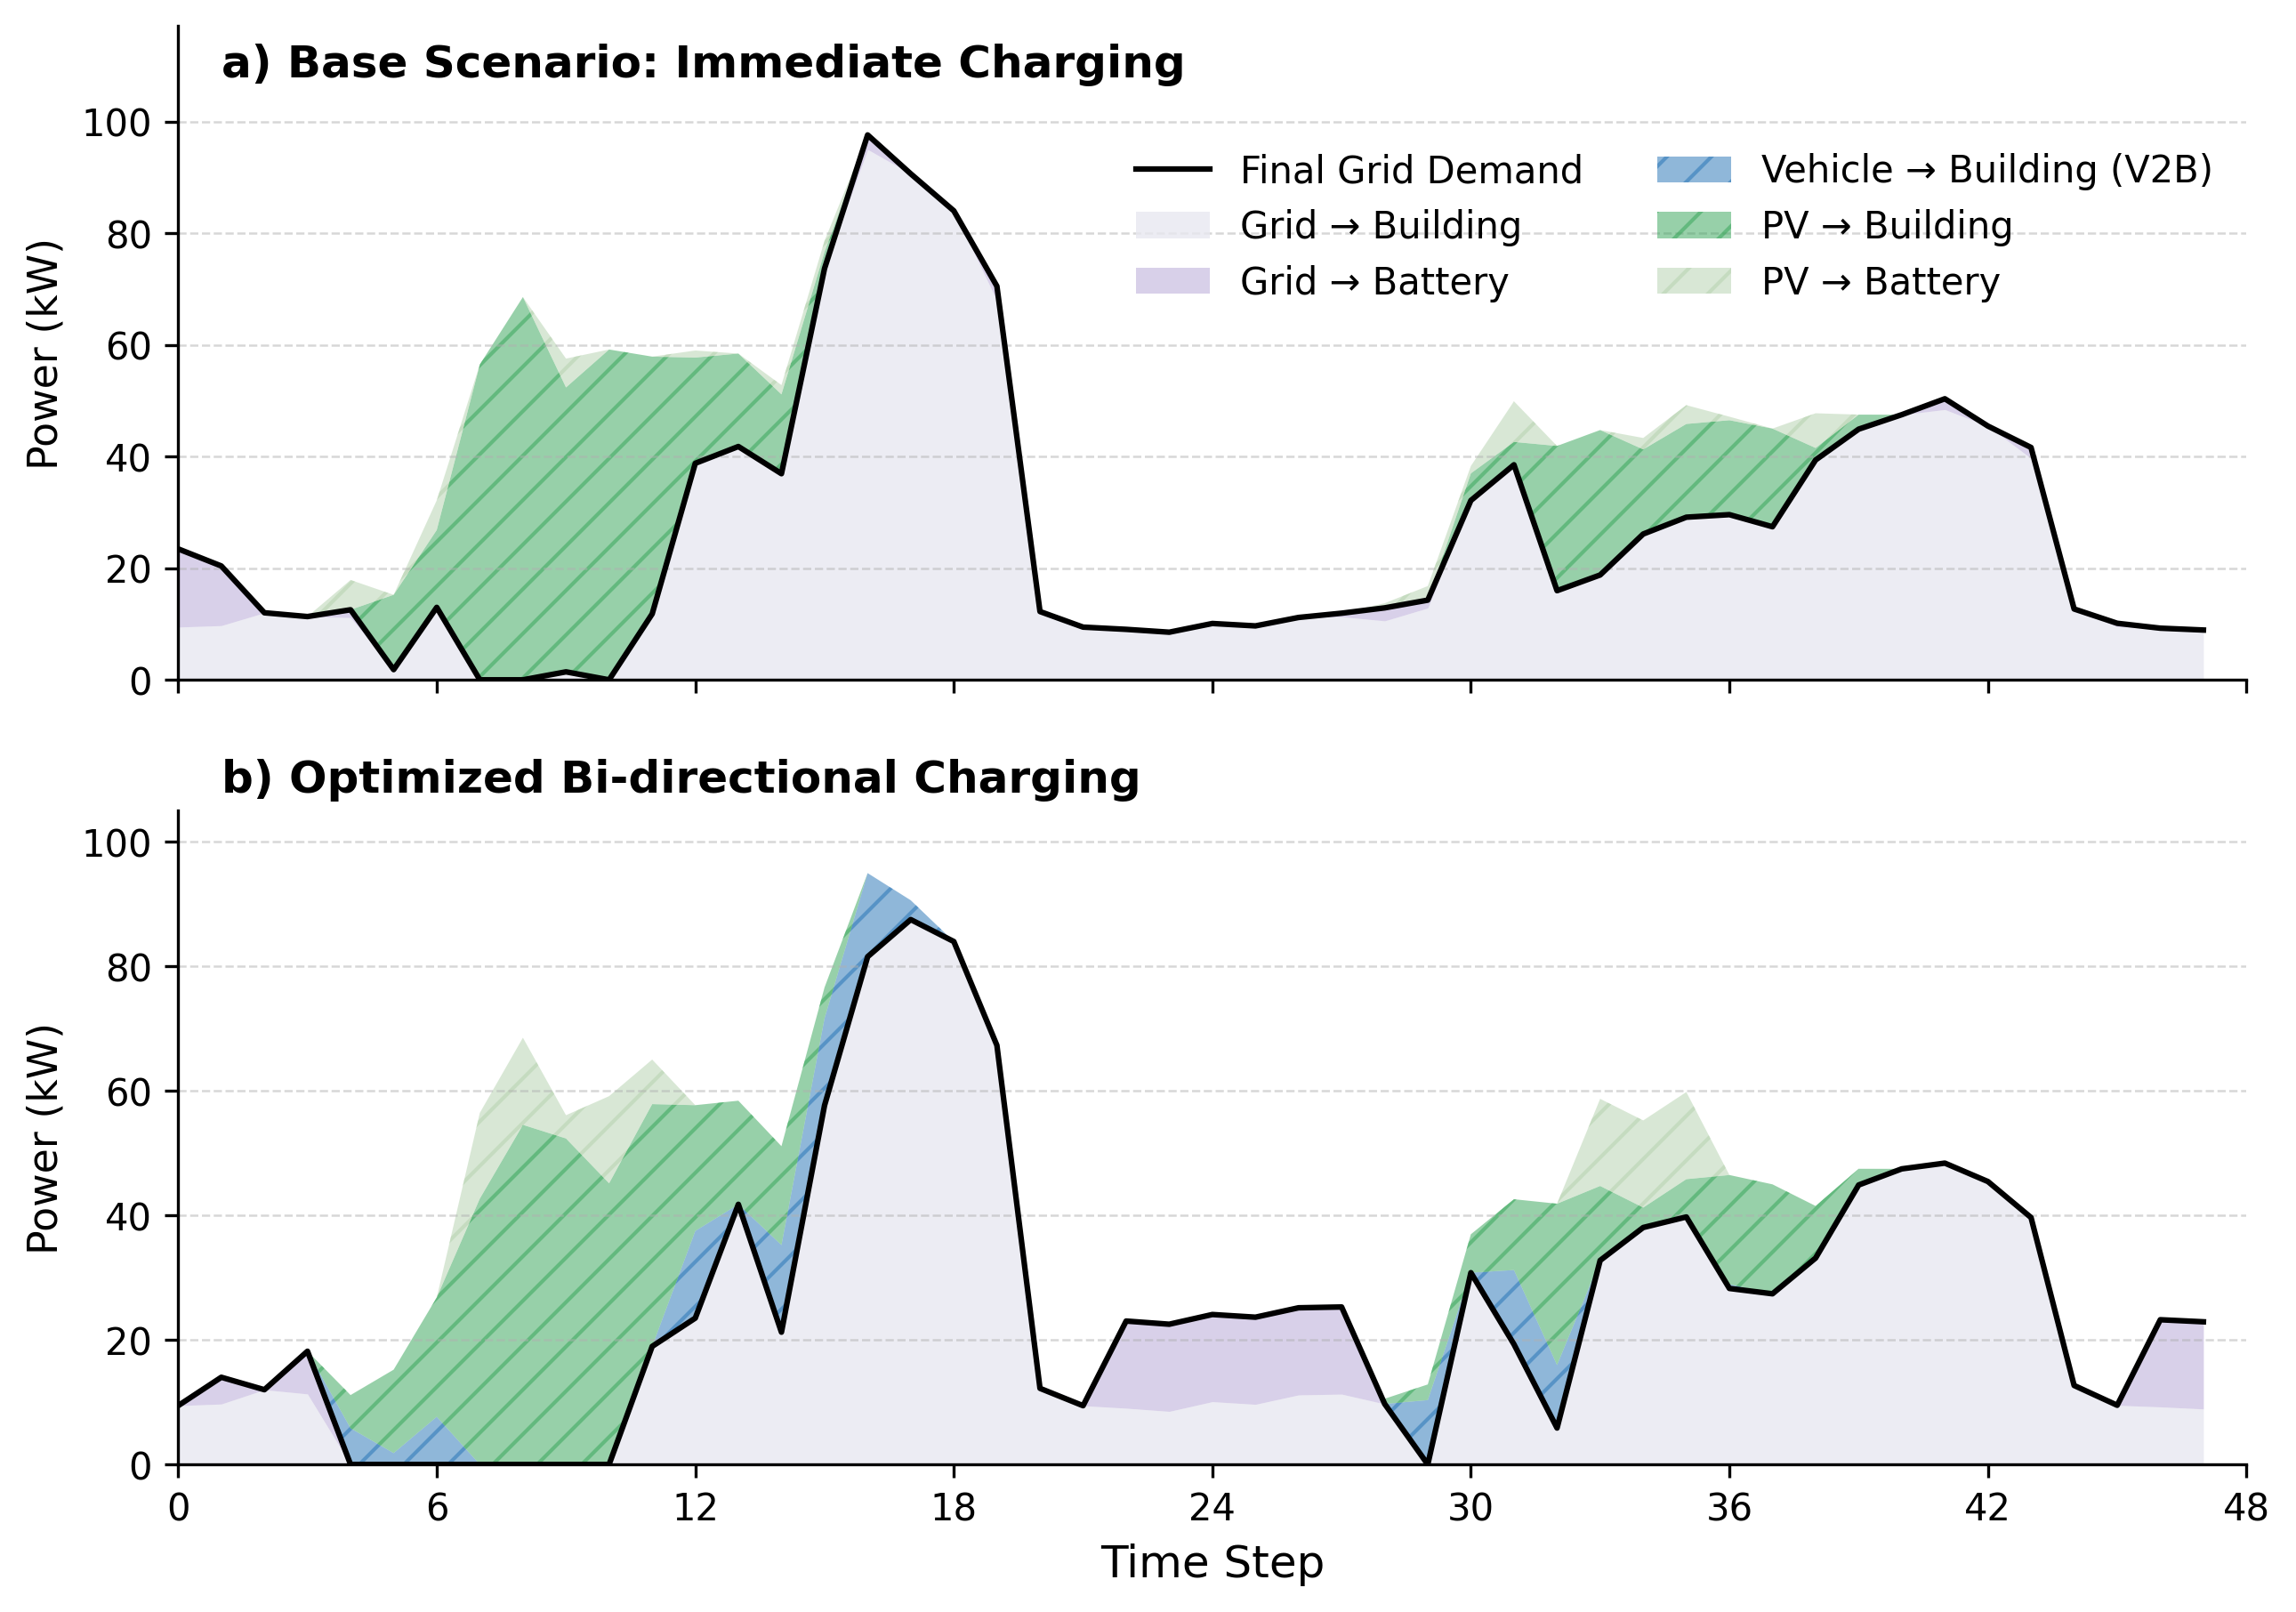

In [3]:

random.seed(25)
random_idx = random.randint(0, len(charging_demands) - 1)
random_idx

# =============================
# 1. Base Data Extraction
# =============================
selected_charging = charging_demands[random_idx]
selected_grid_final = final_grid_demands[random_idx]

selected_charging_immediate = charging_demands_immediate[random_idx]
selected_grid_immediate = final_grid_demands_immediate[random_idx]

selected_pv = pv_generations_immediate[random_idx]
selected_building = building_energy_demands_immediate[random_idx]

# =============================
# 2. Separate Positive/Negative Charging
# =============================
discharging_demands = np.array([v if v < 0 else 0 for v in selected_charging])
charging_only_demands = np.array([v if v > 0 else 0 for v in selected_charging])

discharging_demands_immediate = np.array([v if v < 0 else 0 for v in selected_charging_immediate])
charging_only_demands_immediate = np.array([v if v > 0 else 0 for v in selected_charging_immediate])

time_steps = np.arange(len(selected_charging))

# =============================
# 3. Energy Flow Computation Function
# =============================
def compute_flows(selected_grid, charging_only, discharging, pv, building):
    """Compute energy flow components for one scenario."""
    vehicle_to_building = -discharging                            # 1. Discharging to building
    pv_to_battery = np.minimum(pv, charging_only)                  # 2. PV → battery first
    pv_to_building = np.maximum(pv - pv_to_battery, 0)             # 3. Remaining PV → building
    grid_to_battery = np.maximum(selected_grid - building, 0)      # 4. Grid → battery if > building
    grid_to_building = np.maximum(selected_grid - grid_to_battery, 0)   # 5. Remaining grid → building
    grid_to_building = np.maximum(grid_to_building, 0)             # avoid negatives
    return {
        "vehicle_to_building": vehicle_to_building,
        "pv_to_battery": pv_to_battery,
        "pv_to_building": pv_to_building,
        "grid_to_battery": grid_to_battery,
        "grid_to_building": grid_to_building
    }

flows_final = compute_flows(selected_grid_final, charging_only_demands, discharging_demands, selected_pv, selected_building)
flows_immediate = compute_flows(selected_grid_immediate, charging_only_demands_immediate, discharging_demands_immediate, selected_pv, selected_building)

# =============================
# 4. Plot Configuration
# =============================
labels = [
    "Grid → Building",
    "Grid → Battery",
    "Vehicle → Building (V2B)",
    "PV → Building",
    "PV → Battery"
]
colors = ["#bcbddc", "#756bb1", "#3182bd", "#31a354", "#a1d99b"]  # lavender-gray, medium purple, blue, green, light green
#     "grid_to_building": "#bcbddc",   # lavender-gray
#     "grid_to_battery":  "#756bb1",   # medium purple
#     "vehicle_to_building": "#3182bd",# blue
#     "pv_to_building":    "#31a354",  # green
#     "pv_to_battery":     "#a1d99b"   # light green
# }

colors = [
    "#e8e8f0",  # 0. Grid → Building  (very light lavender gray)
    "#b2a2d4",  # 1. Grid → Battery   (muted violet)
    "#2171b5",   # 4. Vehicle → Building (Discharging) (strong blue)
    "#31a354",  # 3. PV → Building    (medium green)
    "#b3d1ac"  # 2. PV → Battery     (pale green)
]

hatches = [None, None, "//", "//", "//"]

scenarios = [
    ("a) Base Scenario: Immediate Charging", selected_grid_immediate, flows_immediate),
    ("b) Optimized Bi-directional Charging", selected_grid_final, flows_final)
]

# =============================
# 5. Plotting
# =============================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), dpi=300, sharex=True)

for ax, (title, grid_demand, flow) in zip(axes, scenarios):

    # bottom cumulative variable
    cumulative = np.zeros_like(time_steps, dtype=float)
    
    # --- Plot total grid demand line ---
    ax.plot(grid_demand, color='black', linewidth=1.5, label='Final Grid Demand')
    
    # --- Stack 1: Grid → Building ---
    ax.fill_between(time_steps, cumulative, cumulative + flow["grid_to_building"],
                    color=colors[0], alpha=0.8, label=labels[0], linewidth=0)
    cumulative += flow["grid_to_building"]

    # --- Stack 2: Grid → Battery ---
    ax.fill_between(time_steps, cumulative, cumulative + flow["grid_to_battery"],
                    color=colors[1], alpha=0.5, label=labels[1], linewidth=0)
    cumulative += flow["grid_to_battery"]

    # --- Stack 3: Vehicle → Building (Discharging) ---
    ax.fill_between(time_steps, grid_demand, grid_demand + flow["vehicle_to_building"],
                    color=colors[2], alpha=0.5, hatch=hatches[2], label=labels[2], linewidth=0)

    # --- Stack 4: PV → Building ---
    ax.fill_between(time_steps,
                    grid_demand + flow["vehicle_to_building"],
                    grid_demand + flow["vehicle_to_building"] + flow["pv_to_building"],
                    color=colors[3], alpha=0.5, hatch=hatches[3], label=labels[3], linewidth=0)

    # --- Stack 5: PV → Battery ---
    ax.fill_between(time_steps,
                    grid_demand + flow["vehicle_to_building"] + flow["pv_to_building"],
                    grid_demand + flow["vehicle_to_building"] + flow["pv_to_building"] + flow["pv_to_battery"],
                    color=colors[4], alpha=0.5, hatch=hatches[4], label=labels[4], linewidth=0)
    


    # --- Axes styling ---
    ax.text(1,108,title, fontsize=12,fontweight = 'bold')
    ax.set_ylabel('Power (kW)', fontsize=11)
    ax.set_ylim(0, np.max(grid_demand + flow["pv_to_battery"]) * 1.2)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.6, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0, 48)
    ax.set_xticks(np.arange(0, 49, 6))

# Shared bottom x-axis label
axes[-1].set_xlabel('Time Step', fontsize=12)

# Shared legend
handles, labels_all = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels_all, loc='upper right', ncol=2, frameon=False, fontsize=10, bbox_to_anchor=(0.9, 0.83))

# plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [6]:
print(random_idx)
immediate_cost = total_costs_immediate[random_idx]
v2b_cost =(4931.03057)

immediate_utilization = pv_utilizations_immediate[random_idx]
v2b_utilization = pv_utilizations[random_idx]

immediate_self_sufficiency = self_sufficiencies_immediate[random_idx]
v2b_self_sufficiency = self_sufficiencies[random_idx]

96


In [7]:
# === 1. Select Scenario ===
print(f"Scenario index: {random_idx}")

# === 2. Extract Indicator Values ===
immediate_cost = total_costs_immediate[random_idx]
v2b_cost = 4931.03057  # or total_costs[random_idx] if available

immediate_utilization = pv_utilizations_immediate[random_idx]
v2b_utilization = pv_utilizations[random_idx]

immediate_self_sufficiency = self_sufficiencies_immediate[random_idx]
v2b_self_sufficiency = self_sufficiencies[random_idx]

immediate_final_grid = np.sum(final_grid_demands_immediate[random_idx])
v2b_final_grid = np.sum(final_grid_demands[random_idx])

# === 3. Compute Percentage Reductions / Improvements ===
def percent_change(new, old):
    """Return percentage change from old → new (positive = reduction)."""
    return ((old - new) / old) * 100 if old != 0 else np.nan

cost_reduction = percent_change(v2b_cost, immediate_cost)
grid_demand_reduction = percent_change(v2b_final_grid, immediate_final_grid)
pv_utilization_improvement = ((v2b_utilization - immediate_utilization) / immediate_utilization) * 100
self_sufficiency_improvement = ((v2b_self_sufficiency - immediate_self_sufficiency) / immediate_self_sufficiency) * 100

# === 4. Display Results ===
print(f"💰 Cost Reduction: {cost_reduction:.2f}%")
print(f"⚡ Grid Demand Reduction: {grid_demand_reduction:.2f}%")
print(f"🌞 PV Utilization Improvement: {pv_utilization_improvement:.2f}%")
print(f"🏠 Self-Sufficiency Improvement: {self_sufficiency_improvement:.2f}%")


Scenario index: 96
💰 Cost Reduction: 9.01%
⚡ Grid Demand Reduction: 1.29%
🌞 PV Utilization Improvement: 8.53%
🏠 Self-Sufficiency Improvement: 21.38%


In [8]:
import numpy as np
import pandas as pd

# === 1. Select Scenario ===
print(f"Scenario index: {random_idx}")

# === 2. Extract Indicator Values ===
immediate_cost = total_costs_immediate[random_idx]
v2b_cost = 4931.03057  # or total_costs[random_idx] if available

immediate_utilization = pv_utilizations_immediate[random_idx]
v2b_utilization = pv_utilizations[random_idx]

immediate_self_sufficiency = self_sufficiencies_immediate[random_idx]
v2b_self_sufficiency = self_sufficiencies[random_idx]

immediate_final_grid = np.sum(final_grid_demands_immediate[random_idx])
v2b_final_grid = np.sum(final_grid_demands[random_idx])

# === 3. Compute Percentage Change Helper ===
def percent_change(new, old):
    """Return percentage change (positive = reduction for cost/grid, improvement for others)."""
    return ((new - old) / old) * 100 if old != 0 else np.nan

# === 4. Compute Changes ===
data = {
    "Indicator": [
        "Total Cost (TWD)",
        "Grid Demand (kWh)",
        "PV Utilization (%)",
        "Self-Sufficiency (%)"
    ],
    "Before (Immediate)": [
        immediate_cost,
        immediate_final_grid,
        immediate_utilization,
        immediate_self_sufficiency
    ],
    "After (V2B)": [
        v2b_cost,
        v2b_final_grid,
        v2b_utilization,
        v2b_self_sufficiency
    ],
}

df = pd.DataFrame(data)

# Compute percentage change (improvement or reduction)
df["Change (%)"] = [
    percent_change(v2b_cost, immediate_cost),           # cost (↓ better)
    percent_change(v2b_final_grid, immediate_final_grid), # grid demand (↓ better)
    percent_change(v2b_utilization, immediate_utilization), # PV utilization (↑ better)
    percent_change(v2b_self_sufficiency, immediate_self_sufficiency) # self-sufficiency (↑ better)
]

# Adjust direction: cost and grid demand are *reductions*
df.loc[0:1, "Change (%)"] *= -1

# === 5. Display ===
print("\n=== Performance Comparison ===")
print(df.to_string(index=False, formatters={
    "Before (Immediate)": "{:,.2f}".format,
    "After (V2B)": "{:,.2f}".format,
    "Change (%)": "{:+.2f}%".format
}))


Scenario index: 96

=== Performance Comparison ===
           Indicator Before (Immediate) After (V2B) Change (%)
    Total Cost (TWD)           5,419.25    4,931.03     +9.01%
   Grid Demand (kWh)           1,278.77    1,262.22     +1.29%
  PV Utilization (%)               0.91        0.99     +8.53%
Self-Sufficiency (%)               0.28        0.34    +21.38%
